In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
import gymnasium 

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
# !pip3 install --upgrade stable_baselines3
# !pip3 install gym==0.22.0 

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=7, height=7, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
# @autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
# autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

# @autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

# autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
#                        lambda: print('err: gradient undefined'),
#                        lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
#         self.seed=0
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)
#         print(tmp, const)
        
        self.step_+=1
        
#         self.reward+=(1/self.tmp)**2
        self.reward=(1/self.tmp)**2
#         self.reward+=(1/self.tmp)**0.5

       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if self.const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=10e6

In [16]:
# Create log dir
log_dir = "/tmp/gym6/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv

env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [18]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 3000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 5000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 7000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 9000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 11000
Best mean reward: 0.00 - Las

Num timesteps: 100000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 101000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 102000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 103000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 104000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 105000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 106000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 107000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 108000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 109000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 110000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 111000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 1

Num timesteps: 188000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 189000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 190000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 191000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 192000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 193000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 194000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 195000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 196000
Best mean reward: 0.01

Num timesteps: 266000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 267000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 268000
Best mean reward: 0.01 - Last mean reward per episode: 0.02
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 269000
Best mean reward: 0.02 - Last mean reward per episode: 0.02
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 270000
Best mean reward: 0.02 - Last mean reward per episode: 0.02
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 271000
Best mean reward: 0.02 - Last mean reward per episode: 0.02
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 272000
Best mean reward: 0.02 - Last mean reward per episode: 0.02
Num timesteps: 273000
Best mean reward: 0.02 - Last mean reward per episode: 0.02
Num timesteps: 274000
Best mean reward: 0.02

Num timesteps: 341000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 342000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 343000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 344000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 345000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 346000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 347000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 348000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 349000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timestep

Num timesteps: 424000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 425000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 426000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 427000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 428000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 429000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 430000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 431000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 432000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym6/best_model.zip
Num timestep

Num timesteps: 516000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 517000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 518000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 519000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 520000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 521000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 522000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 523000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 524000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 525000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 526000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 527000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 5

Num timesteps: 615000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 616000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 617000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 618000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 619000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 620000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 621000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 622000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 623000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 624000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 625000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 626000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6

Num timesteps: 713000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 714000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 715000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 716000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 717000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 718000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 719000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 720000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 721000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 722000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 723000
Best mean reward: 0.05 - Last mean reward per episode: 0.0

Num timesteps: 812000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 813000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 814000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 815000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 816000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 817000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 818000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 819000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 820000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 821000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 822000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 823000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8

Num timesteps: 909000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 910000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6/best_model.zip
Num timesteps: 911000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 912000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 913000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 914000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 915000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 916000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 917000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 918000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 919000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 920000
Best mean reward: 0.05 - L

Num timesteps: 1002000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1003000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1004000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1005000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1006000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1007000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1008000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1009000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1010000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1011000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1012000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1013000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 1101000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1102000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1103000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1104000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1105000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1106000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1107000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1108000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1109000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1110000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1111000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1112000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 1200000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1201000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1202000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1203000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1204000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1205000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1206000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1207000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1208000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1209000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1210000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1211000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 1299000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1300000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1301000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1302000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1303000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1304000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1305000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1306000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1307000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1308000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1309000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1310000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 1398000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1399000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1400000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1401000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1402000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1403000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1404000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1405000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1406000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1407000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1408000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1409000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 1497000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1498000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1499000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1500000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1501000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1502000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1503000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1504000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1505000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1506000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1507000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1508000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 1596000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1597000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1598000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1599000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1600000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1601000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1602000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1603000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1604000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1605000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1606000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1607000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 1695000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1696000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1697000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1698000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1699000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1700000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1701000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1702000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1703000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1704000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1705000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1706000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 1794000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1795000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1796000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1797000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1798000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1799000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1800000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1801000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1802000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1803000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1804000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1805000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 1893000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1894000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1895000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1896000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1897000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1898000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1899000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1900000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1901000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1902000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1903000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 1904000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 1992000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1993000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1994000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1995000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1996000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1997000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1998000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 1999000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2000000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2001000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2002000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2003000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2091000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2092000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2093000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2094000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2095000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2096000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2097000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2098000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2099000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2100000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2101000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2102000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 2190000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2191000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2192000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2193000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2194000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2195000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2196000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2197000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2198000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2199000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2200000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2201000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 2289000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2290000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2291000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2292000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2293000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2294000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2295000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2296000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2297000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2298000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2299000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2300000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2388000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2389000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2390000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2391000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2392000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2393000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2394000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2395000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2396000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2397000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2398000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2399000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2487000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2488000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2489000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2490000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2491000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2492000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2493000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2494000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2495000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 2496000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2497000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2498000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2586000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2587000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2588000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2589000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2590000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2591000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2592000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2593000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2594000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2595000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2596000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2597000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2685000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2686000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2687000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2688000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2689000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2690000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2691000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2692000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2693000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2694000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2695000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2696000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2784000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2785000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2786000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2787000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2788000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2789000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2790000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2791000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2792000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2793000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2794000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2795000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2883000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2884000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2885000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2886000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2887000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2888000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2889000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2890000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2891000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2892000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2893000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2894000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 2982000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2983000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2984000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2985000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2986000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2987000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2988000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2989000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2990000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2991000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2992000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 2993000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 3081000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3082000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3083000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3084000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3085000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3086000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3087000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3088000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3089000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3090000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3091000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3092000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 3180000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3181000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3182000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3183000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3184000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3185000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3186000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3187000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3188000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3189000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3190000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3191000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 3279000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3280000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3281000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3282000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3283000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3284000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3285000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3286000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3287000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3288000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3289000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3290000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 3378000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3379000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3380000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3381000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3382000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3383000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3384000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3385000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3386000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3387000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3388000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3389000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 3475000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3476000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3477000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3478000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3479000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3480000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3481000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3482000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3483000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3484000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3485000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3486000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 3574000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3575000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3576000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3577000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3578000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3579000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3580000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3581000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3582000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3583000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3584000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3585000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 3673000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3674000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3675000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3676000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3677000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3678000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3679000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3680000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3681000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3682000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3683000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3684000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 3772000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3773000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3774000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3775000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3776000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3777000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3778000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3779000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3780000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3781000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3782000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3783000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 3871000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3872000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3873000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3874000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3875000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3876000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3877000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3878000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3879000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3880000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3881000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3882000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 3967000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3968000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3969000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3970000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3971000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3972000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3973000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3974000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3975000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3976000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3977000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 3978000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 4066000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4067000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4068000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4069000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4070000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4071000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4072000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4073000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4074000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4075000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4076000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4077000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 4165000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4166000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4167000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4168000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4169000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4170000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4171000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4172000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4173000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4174000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4175000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4176000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 4264000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4265000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4266000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4267000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4268000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4269000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4270000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4271000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4272000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4273000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4274000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4275000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 4363000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4364000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4365000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4366000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4367000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4368000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4369000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4370000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4371000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4372000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4373000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4374000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 4462000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4463000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4464000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4465000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4466000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4467000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4468000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4469000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4470000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4471000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4472000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4473000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 4561000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4562000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4563000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4564000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4565000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4566000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4567000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4568000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4569000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4570000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4571000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4572000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 4660000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4661000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4662000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4663000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4664000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4665000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4666000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4667000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4668000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4669000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4670000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4671000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 4759000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4760000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4761000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4762000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4763000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4764000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4765000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4766000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4767000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4768000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4769000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4770000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 4858000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4859000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4860000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4861000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4862000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4863000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4864000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4865000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4866000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4867000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4868000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4869000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 4957000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4958000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4959000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4960000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4961000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4962000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4963000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4964000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4965000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4966000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4967000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 4968000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5056000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5057000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5058000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5059000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5060000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5061000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5062000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5063000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5064000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5065000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5066000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5067000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5155000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5156000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5157000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5158000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5159000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5160000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5161000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5162000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5163000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5164000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5165000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5166000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 5254000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5255000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5256000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5257000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5258000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5259000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5260000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5261000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5262000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5263000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5264000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5265000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5353000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5354000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5355000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5356000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5357000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5358000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5359000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5360000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5361000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5362000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5363000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5364000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 5452000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5453000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5454000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5455000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5456000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5457000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5458000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5459000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5460000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5461000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5462000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5463000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5551000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5552000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5553000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5554000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5555000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5556000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5557000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5558000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5559000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5560000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5561000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5562000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5650000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5651000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5652000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5653000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5654000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5655000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5656000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5657000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5658000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5659000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5660000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5661000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5749000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5750000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5751000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5752000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5753000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5754000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5755000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5756000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5757000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5758000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5759000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5760000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 5848000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5849000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5850000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5851000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5852000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5853000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5854000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5855000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5856000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5857000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5858000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 5859000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 5947000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5948000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5949000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5950000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5951000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5952000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5953000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5954000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5955000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5956000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5957000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 5958000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6046000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6047000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6048000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6049000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6050000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6051000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6052000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6053000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6054000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6055000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6056000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6057000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6145000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6146000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6147000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6148000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6149000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6150000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6151000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6152000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6153000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6154000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6155000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6156000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6244000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6245000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6246000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6247000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6248000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6249000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6250000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6251000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6252000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6253000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6254000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6255000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 6343000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6344000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6345000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6346000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6347000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6348000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6349000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6350000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6351000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6352000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6353000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6354000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6442000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6443000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6444000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6445000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6446000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6447000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6448000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6449000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6450000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6451000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6452000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6453000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6541000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6542000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6543000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6544000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6545000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6546000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6547000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6548000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6549000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6550000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6551000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6552000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6640000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6641000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6642000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6643000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6644000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6645000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6646000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6647000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6648000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6649000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6650000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6651000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6739000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6740000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6741000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6742000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6743000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6744000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6745000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6746000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6747000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6748000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6749000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6750000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 6838000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6839000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6840000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6841000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6842000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6843000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6844000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6845000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6846000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6847000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6848000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6849000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 6937000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6938000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 6939000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6940000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6941000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6942000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6943000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6944000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6945000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6946000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6947000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 6948000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7035000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7036000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7037000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7038000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7039000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7040000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7041000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7042000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7043000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7044000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7045000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7046000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7134000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7135000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7136000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7137000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7138000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7139000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7140000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7141000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7142000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7143000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7144000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7145000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7233000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7234000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7235000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7236000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7237000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7238000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7239000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7240000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7241000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7242000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7243000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7244000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7332000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7333000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7334000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7335000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7336000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7337000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7338000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7339000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7340000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7341000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7342000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7343000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7431000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7432000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7433000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7434000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7435000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7436000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7437000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7438000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7439000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7440000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7441000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7442000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7530000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7531000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7532000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7533000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7534000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7535000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7536000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7537000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7538000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7539000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7540000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7541000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7629000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7630000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7631000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7632000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7633000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7634000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7635000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7636000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7637000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7638000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7639000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7640000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 7728000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7729000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7730000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7731000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7732000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7733000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7734000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7735000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7736000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7737000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7738000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7739000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 7827000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7828000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7829000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7830000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7831000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7832000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7833000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7834000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7835000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7836000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7837000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7838000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 7926000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7927000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7928000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7929000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7930000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7931000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7932000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 7933000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7934000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7935000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7936000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 7937000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 8025000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8026000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8027000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8028000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8029000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8030000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8031000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8032000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8033000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8034000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8035000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8036000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8124000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8125000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8126000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8127000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8128000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8129000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8130000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8131000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8132000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8133000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8134000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8135000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8223000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8224000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8225000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8226000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8227000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8228000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8229000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8230000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8231000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8232000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8233000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8234000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8322000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8323000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8324000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8325000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8326000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8327000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8328000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8329000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8330000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8331000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8332000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8333000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 8421000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8422000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8423000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8424000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8425000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8426000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8427000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8428000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8429000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8430000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8431000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8432000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8520000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8521000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8522000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8523000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8524000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8525000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8526000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8527000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8528000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8529000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8530000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8531000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8619000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8620000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8621000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8622000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8623000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8624000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8625000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8626000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8627000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8628000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8629000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8630000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8718000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8719000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8720000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8721000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8722000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8723000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8724000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8725000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8726000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8727000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8728000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8729000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8817000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8818000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8819000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8820000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8821000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8822000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8823000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8824000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 8825000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8826000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8827000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8828000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 8916000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8917000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8918000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8919000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8920000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8921000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8922000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8923000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8924000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8925000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8926000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8927000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 9015000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9016000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9017000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9018000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9019000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9020000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9021000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9022000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9023000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9024000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9025000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9026000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 9114000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9115000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9116000
Best mean reward: 0.05 - Last mean reward per episode: 0.03
Num timesteps: 9117000
Best mean reward: 0.05 - Last mean reward per episode: 0.03
Num timesteps: 9118000
Best mean reward: 0.05 - Last mean reward per episode: 0.03
Num timesteps: 9119000
Best mean reward: 0.05 - Last mean reward per episode: 0.03
Num timesteps: 9120000
Best mean reward: 0.05 - Last mean reward per episode: 0.03
Num timesteps: 9121000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9122000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9123000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9124000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9125000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 9213000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9214000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9215000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9216000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9217000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9218000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9219000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9220000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9221000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9222000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9223000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9224000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 9312000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9313000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9314000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9315000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9316000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9317000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9318000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9319000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9320000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9321000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9322000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9323000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 9411000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9412000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9413000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9414000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9415000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9416000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9417000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9418000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9419000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9420000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9421000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9422000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 9510000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9511000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9512000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9513000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9514000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9515000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9516000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9517000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9518000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9519000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9520000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9521000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 9609000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9610000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9611000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9612000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9613000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9614000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9615000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9616000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9617000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9618000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9619000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9620000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 9708000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9709000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9710000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9711000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9712000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9713000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9714000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9715000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9716000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9717000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9718000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9719000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

Num timesteps: 9807000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9808000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9809000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9810000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9811000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9812000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9813000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9814000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9815000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9816000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9817000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9818000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num 

Num timesteps: 9906000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9907000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9908000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9909000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9910000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9911000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9912000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9913000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9914000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9915000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9916000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 9917000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num 

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 244.06284829775493 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
obs=obs[0]

In [22]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(int(action))
#     print(env.tmp, env.const)
    
    if dones:
        break
    i+=1

In [23]:
print(i)

49



Final Cantilever beam design:


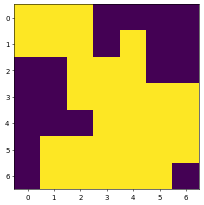

In [24]:
env.render()

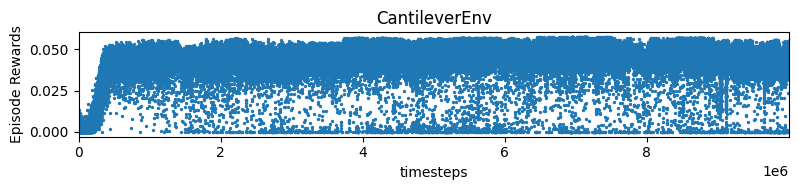

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
#     print(env.tmp, env.const)
    if dones:
        break
    i+=1

In [29]:
i

49


Final Cantilever beam design:


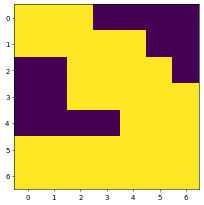

In [30]:
env.render()

In [31]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# different reward 3 
# training ~1.5 hr

# illegal moves reward = -1, terminate ? 

# CNN
# randomize loads 
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 

In [32]:
import random

In [33]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<16*0.68753125:
        action = random.randint(0, 15)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)    

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rd to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rd` for environment variables or `env.get_wrapper_attr('rd')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for

2772436162.7450213 0.18375510204081635
2732976880.002601 0.18375510204081635
4296924658.850454 0.18375510204081635
2738057244.481936 0.12253673469387756
4296204017.517028 0.20416122448979596
3536977106.723144 0.18375510204081635
2781625804.161651 0.18375510204081635
4435453961.151643 0.18375510204081635
2724214920.4338746 0.12253673469387756
2724395687.503331 0.18375510204081635


In [34]:
for j in range(10):
    i=0
    obs=env.reset()
    while i<9*0.68753125:
        action = random.randint(0, 8)

        env.args = get_args(*mbb_beam(rd=env.rd))

        env.M.action_space_(action, env.x)   
        env.tmp, env.const = fast_stopt(env.args, env.x)
        
        i+=1
    print(env.tmp, env.const)   

3769837795.1296825 0.12253673469387756
3798757265.388589 0.08172448979591837
3747902740.6869164 0.12253673469387755
3773087554.776591 0.12253673469387756
6303022973.926748 0.12253673469387756
4188079044.7690816 0.10213061224489797
5947785933.176865 0.14294285714285715
6301025468.460848 0.08172448979591837
3789313043.262437 0.08172448979591837
6191066258.299343 0.12253673469387756
